In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats

from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from transformers import CLIPModel

In [11]:
data_dir = "data"
dataset_id = "20220329222400"

dataset_dir = os.path.join(data_dir, dataset_id)

In [12]:
# read embeds, prices, and ids
text_embeds = np.load(os.path.join(dataset_dir, "text_embeds.npy"))
image_embeds = np.load(os.path.join(dataset_dir, "image_embeds.npy"))

embeds = np.concatenate([text_embeds, image_embeds], axis=1)
embeds = torch.tensor(embeds, dtype=torch.float32)

prices = np.load(os.path.join(dataset_dir, "prices.npy"))
prices = torch.tensor(prices, dtype=torch.float32)

ids = np.load(os.path.join(dataset_dir, "ids.npy"))


In [13]:
print(text_embeds.shape)
print(image_embeds.shape)
print(embeds.shape)
print(prices.shape)

(995, 512)
(995, 512)
torch.Size([995, 1024])
torch.Size([995])


In [14]:
class PriceModelKNN(nn.Module):

    def __init__(self, embeds, prices, top_k=10, balance_factor=0):
        super(PriceModelKNN, self).__init__()
        # normalize embeds
        self.embeds = embeds / torch.norm(embeds, dim=1).unsqueeze(dim=1)
        self.prices = prices
        self.top_k = top_k
        self.balance_factor = balance_factor
        

    def forward(self, x): 
        # x (batch_size, embed_dim)
        # embeds (N, embed_dim)
        # prices (N,)
        scores = torch.matmul(x, self.embeds.t()) # (batch_size, N)
        # top k indices
        top_k_indices = torch.topk(scores, k=self.top_k, dim=1)[1] # (batch_size, top_k)

        top_scores = torch.gather(scores, 1, top_k_indices) # (batch_size, top_k)
        # normalize top scores
        top_scores /= torch.sum(top_scores, dim=1, keepdim=True)
        top_scores += self.balance_factor
        top_scores /= torch.sum(top_scores, dim=1, keepdim=True)
        
        top_prices = self.prices[top_k_indices] # (batch_size, top_k)

        # softmax

        # print("top_scores", top_scores.shape)

        # multiply by prices
        predicted_price = torch.sum(top_scores * top_prices, dim=1) # (batch_size,)
        # print(weights.shape, top_prices.shape, predicted_price.shape)
        
        return predicted_price.cpu().numpy()

In [15]:
train_p, valid_p, test_p = 0.6, 0.2, 0.2

assert train_p + valid_p + test_p == 1, "Train, valid, and test percentages must add up to 1."

n_train = int(len(embeds) * train_p)
n_test = len(embeds) - n_train

training_data = TensorDataset(embeds[:n_train], prices[:n_train])
validation_data = TensorDataset(embeds[n_train:], prices[n_train:])
test_data = TensorDataset(embeds[n_train:], prices[n_train:])


In [16]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)



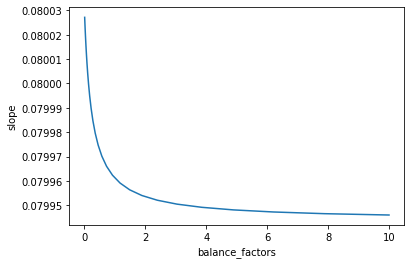

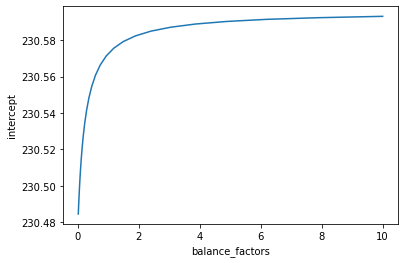

In [35]:
def get_best_fit_params(model, dataloader):
    # predict prices on validation set
    all_preds = []
    all_prices = []
    with torch.no_grad():
        for x, y in dataloader:
            model.eval()
            preds = model(x)
            all_preds.append(preds)
            all_prices.append(y.cpu().numpy())

    # flatten lists
    all_preds = np.concatenate(all_preds)
    all_prices = np.concatenate(all_prices)

    slope, intercept, r_value, p_value, std_err = stats.linregress(all_prices, all_preds)

    return slope, intercept

slopes = []
intercepts = []
balance_factors = np.geomspace(0.01, 10, num=30)
for bf in balance_factors:
    model = PriceModelKNN(embeds[:n_train], prices[:n_train], top_k=4, balance_factor=bf)
    slope, intercept = get_best_fit_params(model, validation_dataloader)
    slopes.append(slope)
    intercepts.append(intercept)

# plot slope vs top_k
plt.plot(balance_factors, slopes)
plt.xlabel("balance_factors")
plt.ylabel("slope")
plt.show()

# plot intercept vs top_k
plt.plot(balance_factors, intercepts)
plt.xlabel("balance_factors")
plt.ylabel("intercept")
plt.show()


Slope: 0.35420333875867
Intercept: 150.66897709627085


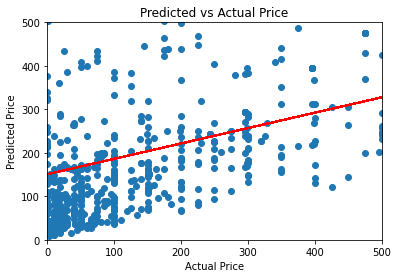

Slope: 0.08003043938148607
Intercept: 230.48005217846006


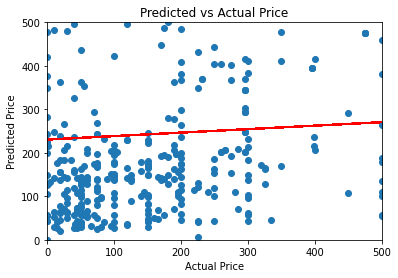

In [36]:
def scatter_predict_vs_actual(model, dataloader):
    # predict prices on validation set
    all_preds = []
    all_prices = []
    with torch.no_grad():
        for x, y in dataloader:
            model.eval()
            preds = model(x)
            all_preds.append(preds)
            all_prices.append(y.cpu().numpy())

    # flatten lists
    all_preds = np.concatenate(all_preds)
    all_prices = np.concatenate(all_prices)

    # Scatter plot of predicted prices vs actual prices
    plt.scatter(all_prices, all_preds)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Predicted vs Actual Price")
    # make axis the same scale
    global_min = min(all_prices.min(), all_preds.min())
    global_max = max(all_prices.max(), all_preds.max())
    global_max = 500
    plt.xlim(global_min, global_max)
    plt.ylim(global_min, global_max)

    # plot a line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_prices, all_preds)
    plt.plot(all_prices, slope*all_prices + intercept, color="red")
    # print the slope of the line
    print("Slope:", slope)
    # print intercept
    print("Intercept:", intercept)


    plt.show()

model = PriceModelKNN(embeds[:n_train], prices[:n_train], top_k=4, balance_factor=0)

scatter_predict_vs_actual(model, train_dataloader)
scatter_predict_vs_actual(model, test_dataloader)